# Time Series Forecasting For 1 Month In March 2020

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
from matplotlib import pyplot
#style.use('ggplot')

import datetime
from datetime import time

import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# import warnings
# warnings.filterwarnings('ignore')

from forecast_tools.baseline import Naive1, Drift, SNaive, Average, baseline_estimators
from forecast_tools.metrics import coverage, mean_absolute_percentage_error

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from sklearn.metrics import mean_squared_error, mean_absolute_error

from math import sqrt

from sklearn.svm import SVR

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima

### Import data

In [2]:
data = pd.read_csv('march_2020_training.csv', index_col = 'date', parse_dates=True)
#data = pd.read_csv('october_2018_training.csv', index_col = 'date', parse_dates=True)
#data = pd.read_csv('csv_agile_C_London.csv', index_col = 'date', parse_dates=True)
#dataHist = pd.read_csv('march_2020_training.csv', parse_dates=True) 
# parse dates = True allows pandas to know that it is dealing with dates
data.index.freq = '30t'
print(data.index.dtype)
print(data.shape)

datetime64[ns, UTC]
(1488, 1)


In [3]:
data

,price
date,
2020-03-01 00:00:00+00:00,2.205
2020-03-01 00:30:00+00:00,4.410
2020-03-01 01:00:00+00:00,3.780
2020-03-01 01:30:00+00:00,2.163
2020-03-01 02:00:00+00:00,2.520
...,...
2020-03-31 21:30:00+00:00,7.035
2020-03-31 22:00:00+00:00,6.930
2020-03-31 22:30:00+00:00,5.880


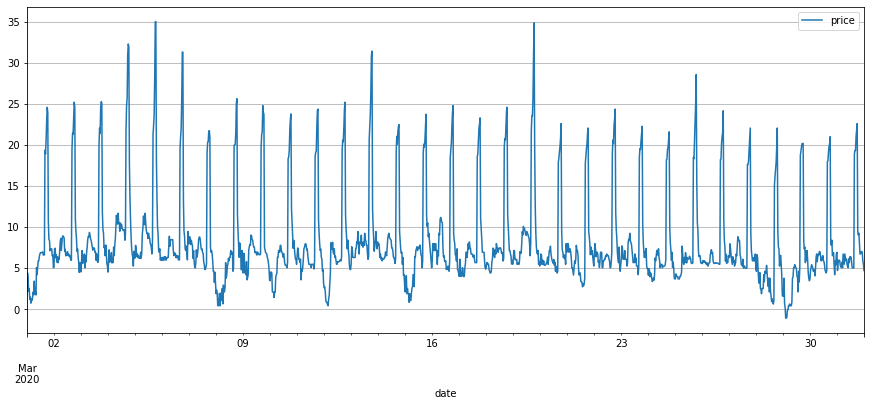

In [4]:
ax=data.plot(figsize=(15, 6))
ax.grid()

## Check for stationarity

Time series forecasting there are many assumptions that are needed, these model assumptions are violated in time series by the addition of time-dependent values such as trend, seasonality etc. and will lead to poor, inaccurate forecasts <br><br>
Time series are stationary if they do not have trend or seasonal effects<br>
<b>Trend:</b> Describes movment of data values at regular intervals e.g. movement of data moving up over time is an upward trend <br>
<b>Seasonality:</b> Continues trend that repeats itself after a fixed intervals of time<br><br>
Linear regression model needs to prepare data by a degree of differencing so it is not stationary (remove trend and seasonal patterns that will negatively affect the regression model) 


Stationarity is decided on 3 criteria:<br>
1. it should have constant mean 
2. It should have constant variance
3. Auto covariance does not depend on time (relationship between any 2 values at a certain amount of time)<br><br>
In a non-stationary series, these properties are dependent on time.

In [5]:
price = data['price']
price

date
2020-03-01 00:00:00+00:00    2.205
2020-03-01 00:30:00+00:00    4.410
2020-03-01 01:00:00+00:00    3.780
2020-03-01 01:30:00+00:00    2.163
2020-03-01 02:00:00+00:00    2.520
                             ...  
2020-03-31 21:30:00+00:00    7.035
2020-03-31 22:00:00+00:00    6.930
2020-03-31 22:30:00+00:00    5.880
2020-03-31 23:00:00+00:00    5.544
2020-03-31 23:30:00+00:00    4.704
Freq: 30T, Name: price, Length: 1488, dtype: float64

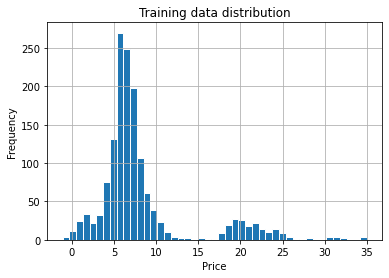

In [6]:
ax=plt.hist(price, bins=45, edgecolor='white', linewidth=1)
plt.title('Training data distribution')
plt.ylabel('Frequency')
plt.xlabel('Price');
plt.grid()

Can see it is basically gaussianlly distributed with a long tail

### Augmented Dickey-Fuller test

It is a statistical test called a unit root test.
Unit root tests show how strongly a time series is defined by trend.

To perform this test, we need do hypothesis testing:<br><br>
Null Hypothesis (H0): series is non stationary or has a series unit root<br><br>
Alternate Hypothesis (H1): Series is stationary or has no unit root<br><br>
Result is determined using p-value from test, we will try, a critical value of 1%, 5%, 10% which are the common values

In [7]:
# result = adfuller(price, autolag ='AIC')
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
# 	print('\t%s: %.3f' % (key, value))

In [77]:
def adfuller_test(price):
    result=adfuller(price)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [78]:
adfuller_test(data['price'])

ADF Test Statistic : -10.127356848757003
p-value : 9.107244790078702e-18
#Lags Used : 23
Number of Observations Used : 1464
ADF Statistic: -10.127357
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


### Rolling statistics test

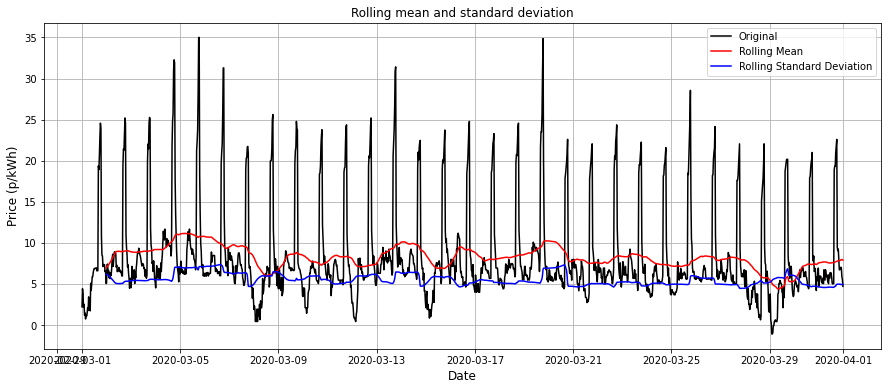

In [49]:
rmean1=price.rolling(window=48).mean()
rstd1=price.rolling(window=48).std()
#print(rmean1,rstd1)
plt.figure(figsize=(15,6))
orig=plt.plot(price , color='black',label='Original')
mean= plt.plot(rmean1 , color='red',label='Rolling Mean')
std=plt.plot(rstd1,color='blue',label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title("Rolling mean and standard deviation")
plt.ylabel("Price (p/kWh)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid()
plt.show(block=False)

#### Observations

<b>Augmented Dickey-Fuller test </b><br>
The result shows that the test statistic is -10.1 which is less than the critical values at all percentages (1%, 5%, 10%). Therefore we can conclude from there that the data is stationary. <br><br>
<b>Rolling Statistics Test</b><br>
This gives us a visual representation of the dataset. We can see that the rolling mean and standard deviation ar constant so the data is stationary

## ARIMA

Arima models are divided into 3 parts:<br><br>
<B>AR:</B> Autoregression. Uses previous values to make future prediction. e.g. second order means using past 2 values<br><br>
<B>I:</B> Integrated. Differencing, If your data is not stationary, you need to difference it with previous values to eliminate trends<br><br>
<B>MA:</B> Moving average. Uses past errors to make a future prediction e.g. moving average of 2 means using past 2 errors<br><br>

#### Finding best ARIMA model

Using auto_arima, it takes into account  AIC (Akaike Information Criterion), which are used for selecting predictors in regression, evaluating how well a model fits the data it was generated from. The better models have lower AIC.

In [219]:
stepWiseFit = auto_arima(data['price'],trace=True, supress_warnings=True, max_p=8, max_q=8, max_order=20)
stepWiseFit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7267.023, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9395.101, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7345.193, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8119.081, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11069.073, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=7299.431, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=7258.063, Time=0.51 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7303.607, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=7296.049, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=7260.035, Time=1.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=7288.308, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=7199.633, Time=1.40 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=7196.483, Time=1.92 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=7220.026, Time=1.43 sec
 ARIMA(5,0,2)(0,0,0)[0] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1488
Model:               SARIMAX(8, 0, 1)   Log Likelihood               -3482.527
Date:                Mon, 07 Feb 2022   AIC                           6987.055
Time:                        11:59:23   BIC                           7045.412
Sample:                             0   HQIC                          7008.804
                               - 1488                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2794      0.121      2.314      0.021       0.043       0.516
ar.L1          1.8950      0.067     28.213      0.000       1.763       2.027
ar.L2         -1.0005      0.100    -10.045      0.000      -1.196      -0.805
ar.L3          0.1315      0.095      1.391      0.164      -0.054       0.317
ar.L4         -0.0715      0.074     -0.965      0.334      -0.217       0.074
ar.L5          0.0602      0.062      0.975      0.330      -0.061       0.181
ar.L6         -0.5017      0.064     -7.778      0.000      -0.628      -0.375
ar.L7          0.8313      0.043     19.204      0.000       0.746       0.916
ar.L8         -0.3786      0.022    -16.992      0.000      -0.422      -0.335
ma.L1         -0.8787      0.059    -14.857      0.000      -0.995      -0.763
sigma2         6.2329      0.156     39.968      0.000       5.927       6.539
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):             11006.66
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             2.17
Prob(H) (two-sided):                  0.08   Kurtosis:                        15.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Correlograms

Autocorrelogram & Partail Autocorrelogram is useful that to estimate each models parameters.<br><br>
Autocorrelation refers to how correlated a time series is with its past values.<br><br>
ACF is the plot to see the correlation between points up to and including the lag unit.<br><br>

In [204]:
acf_values = acf(data['price'])
acf_values

C:\Users\henry\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\henry\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([ 1.        ,  0.86466428,  0.70156638,  0.53959134,  0.37041536,
        0.19669504,  0.02694553, -0.02239725, -0.0529408 , -0.07474045,
       -0.08734372, -0.10172727, -0.10171273, -0.10272442, -0.09923512,
       -0.09795493, -0.09399611, -0.08691531, -0.10168399, -0.11433885,
       -0.12786301, -0.14304728, -0.15533625, -0.1663956 , -0.16390381,
       -0.1704258 , -0.16307035, -0.15302161, -0.13914634, -0.12667381,
       -0.11576589, -0.10255148, -0.11246967, -0.11836117, -0.12129524,
       -0.12725785, -0.12910265, -0.13209742, -0.11897333, -0.10875393,
       -0.08992086])

Blue region is the confidence band. Anything within this range represents a value that has no significant correlation with the most recent value for the price. <br><br>
This lets us know that previous prices influence the current price but the significance of that influence decreases steadily with time. Specifically, values beyond the 5th previous day have no significant predictive power on the current price.

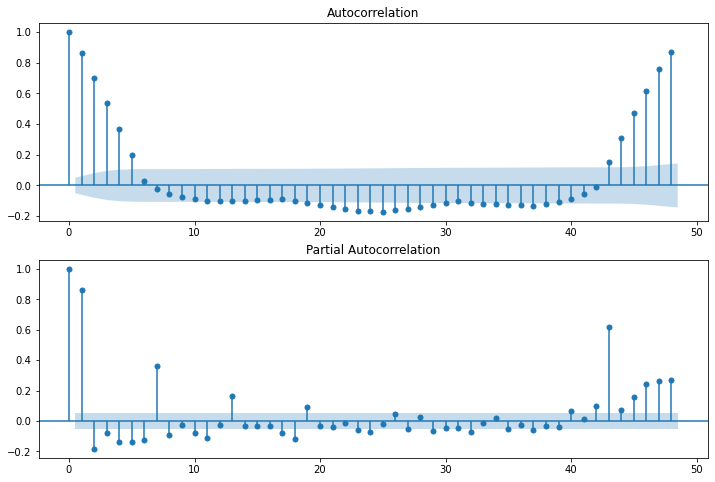

In [205]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['price'], lags=48, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['price'], lags=48, ax=ax2)# , lags=40

#### Train test split the data

In [206]:
data_length = data.shape[0]
split70 = round(data_length*0.7)
train = data.iloc[:split70]
test = data.iloc[split70:]
print(train.shape, test.shape)
print(data_length)

(1042, 1) (446, 1)
1488


#### Train the model

In [212]:
arimamodel = ARIMA(train['price'], order=(8,0,1))
arimamodel = arimamodel.fit()
arimamodel.summary()

C:\Users\henry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 1042
Model:                 ARIMA(8, 0, 1)   Log Likelihood               -2459.758
Date:                Mon, 07 Feb 2022   AIC                           4941.516
Time:                        11:41:41   BIC                           4995.954
Sample:                    03-01-2020   HQIC                          4962.165
                         - 03-22-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6137      0.431     20.005      0.000       7.770       9.458
ar.L1          1.9392      0.067     29.037      0.000       1.808       2.070
ar.L2         -1.0605      0.119     -8.927      0.000      -1.293      -0.828
ar.L3          0.1408      0.120      1.170      0.242      -0.095       0.377
ar.L4         -0.0314      0.091     -0.344      0.731      -0.210       0.147
ar.L5         -0.0050      0.078     -0.064      0.949      -0.158       0.148
ar.L6         -0.4439      0.087     -5.085      0.000      -0.615      -0.273
ar.L7          0.8101      0.055     14.751      0.000       0.702       0.918
ar.L8         -0.3772      0.025    -15.312      0.000      -0.425      -0.329
ma.L1         -0.9154      0.047    -19.331      0.000      -1.008      -0.823
sigma2         6.5646      0.208     31.503      0.000       6.156       6.973
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):              6846.83
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             2.00
Prob(H) (two-sided):                  0.37   Kurtosis:                        14.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

What we can see from here is ...................

#### Make predictions on the test set

In [213]:
start = len(train)
end = len(train) + len(test) - 1
arimapred = arimamodel.predict(start=start, end=end, typ='levels')
arimapred

2020-03-22 17:00:00+00:00    20.518156
2020-03-22 17:30:00+00:00    20.261071
2020-03-22 18:00:00+00:00    19.685285
2020-03-22 18:30:00+00:00    18.753411
2020-03-22 19:00:00+00:00    12.818028
                               ...    
2020-03-31 21:30:00+00:00     8.613660
2020-03-31 22:00:00+00:00     8.613660
2020-03-31 22:30:00+00:00     8.613660
2020-03-31 23:00:00+00:00     8.613660
2020-03-31 23:30:00+00:00     8.613660
Freq: 30T, Name: predicted_mean, Length: 446, dtype: float64

#### Plot prediction

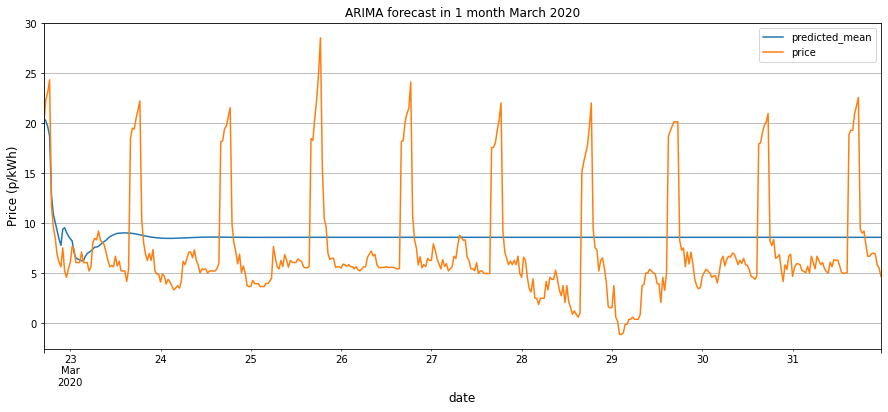

In [214]:
arimapred.plot(legend = True, figsize=(15,6))
plt.title('ARIMA forecast in 1 month March 2020', fontsize=12)
plt.ylabel("Price (p/kWh)", fontsize=12)
plt.xlabel("Date", fontsize=12)
test['price'].plot(legend = True)
plt.grid()

### Check forecast error

#### RMSE

In [215]:
print("ARIMA RMSE: ", sqrt(mean_squared_error(arimapred,test['price'])))
print("ARIMA MSE: ", mean_squared_error(arimapred, test['price']))
print("ARIMA MAE: ", mean_absolute_error(arimapred, test['price']))

ARIMA RMSE:  5.262837840274233
ARIMA MSE:  27.69746213302235
ARIMA MAE:  4.156132907001493


#### Final observations
ARIMA is not a very good model for predicting seasonal data as it does not support time series with seasonal components

# SARIMA

Seasonal Autoregressive Integrated Moving Average is used to forecast data containing trends and seasonality <br><br>
Along with the 3 hyperparameters (p,d,q) that needed to be configured in ARIMA, SARIMA requires 4 additional hyperparamters: (P,D,Q,m)
1. P: Seasonal autogregressive order
2. D: Seasonal difference order
3. Q: Seasonal moving average order
4. m: Number of time steps for a single seasonal period

In [20]:
model = sm.tsa.statespace.SARIMAX(train['price'], order=(4,0,5), seasonal_order=(4,0,5,48))
result = model.fit()

C:\Users\henry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [50]:
sarimapred = result.predict(start=start, end=end, dynamic=True)
sarimapred

2020-03-22 17:00:00+00:00    20.911632
2020-03-22 17:30:00+00:00    22.749932
2020-03-22 18:00:00+00:00    24.684628
2020-03-22 18:30:00+00:00    25.634594
2020-03-22 19:00:00+00:00    11.820216
                               ...    
2020-03-31 21:30:00+00:00     6.681765
2020-03-31 22:00:00+00:00     6.794315
2020-03-31 22:30:00+00:00     5.572240
2020-03-31 23:00:00+00:00     5.971097
2020-03-31 23:30:00+00:00     5.267389
Freq: 30T, Name: predicted_mean, Length: 446, dtype: float64

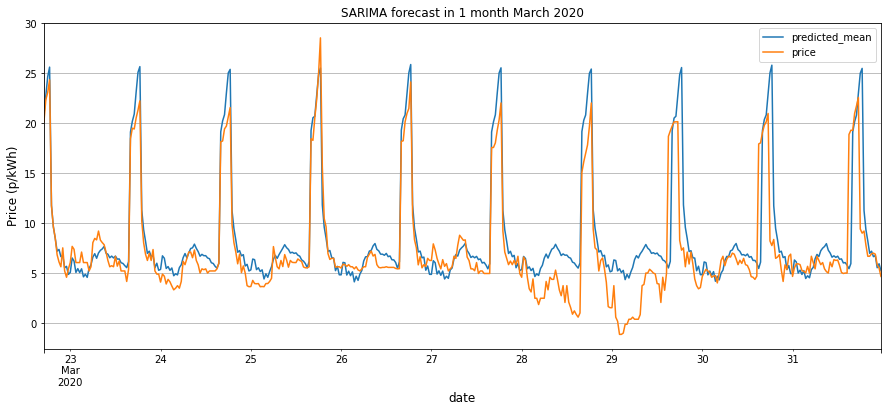

In [52]:
sarimapred.plot(legend = True, figsize=(15,6))
plt.title('SARIMA forecast in 1 month March 2020', fontsize=12)
plt.ylabel("Price (p/kWh)", fontsize=12)
plt.xlabel("Date", fontsize=12)
test['price'].plot(legend = True)
plt.grid()

In [53]:
print("SARIMA RMSE: ", sqrt(mean_squared_error(arimapred,test['price'])))
print("SARIMA MSE: ", mean_squared_error(arimapred, test['price']))
print("SARIMA MAE: ", mean_absolute_error(arimapred, test['price']))

SARIMA RMSE:  5.263427911608155
SARIMA MSE:  27.703673380695783
SARIMA MAE:  4.139516259308257


# FBProphet

In [146]:
def prophet_format_training_data(data):
    '''
    Convert from Pandas dataframe format to Prophet format
    '''
    prophet_train = pd.DataFrame(data.index)
    prophet_train['y'] = data.to_numpy()
    prophet_train.columns = ['ds','y']    
    
    return prophet_train

In [147]:
y_train = prophet_format_training_data(data)
y_train['ds'] = y_train['ds'].dt.tz_localize(None) #get rid of timezone
print(y_train['ds'].dtype)
y_train.head()

datetime64[ns]


,ds,y
0,2020-03-01 00:00:00,2.205
1,2020-03-01 00:30:00,4.410
2,2020-03-01 01:00:00,3.780
3,2020-03-01 01:30:00,2.163
4,2020-03-01 02:00:00,2.520


In [148]:
data_length = data.shape[0]
split70 = round(data_length*0.7)
train = y_train[:split70]
test = y_train[split70:]
print(train.shape, test.shape)
print(data_length)

(1042, 2) (446, 2)
1488


In [156]:
# prophmodel = Prophet(changepoint_prior_scale=0.01) #fit model by instantiating new prophet object
prophmodel = Prophet() #fit model by instantiating new prophet object
prophmodel.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [184]:
future = prophmodel.make_future_dataframe(periods=446, freq='30T')
forecast = prophmodel.predict(future)  
#The predict method will assign each row in future a predicted value which it names yhat

Text(0.5, 1.0, 'Prophet Forecast for non random train test split')

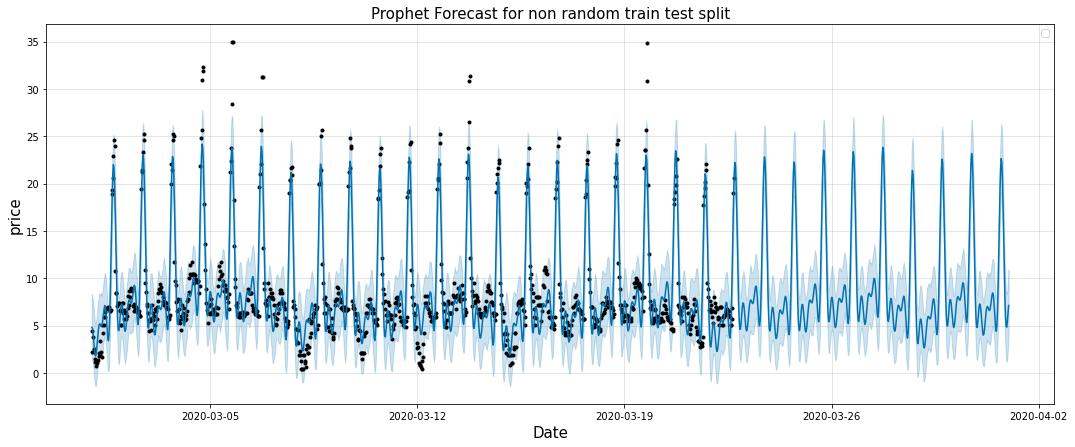

In [185]:
fig = prophmodel.plot(forecast, figsize=(15,6))
plt.ylabel('price', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.legend()
plt.title('Prophet Forecast for non random train test split', fontsize=15)

Text(0.5, 1.0, 'Prophet Forecast for non random train test split')

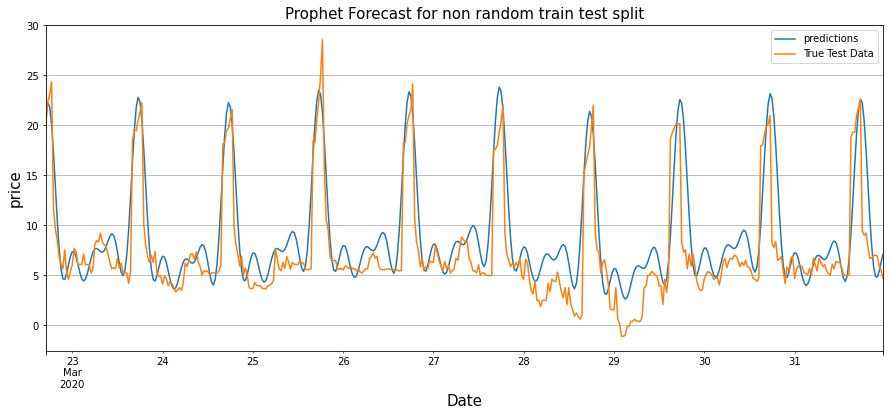

In [191]:
ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions', figsize=(15,6))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax)
plt.grid()
plt.ylabel('price', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.title('Prophet Forecast for non random train test split', fontsize=15)

In [187]:
test.shape[0]
test

,ds,y
1042,2020-03-22 17:00:00,20.160
1043,2020-03-22 17:30:00,22.386
1044,2020-03-22 18:00:00,23.100
1045,2020-03-22 18:30:00,24.360
1046,2020-03-22 19:00:00,11.760
...,...,...
1483,2020-03-31 21:30:00,7.035
1484,2020-03-31 22:00:00,6.930
1485,2020-03-31 22:30:00,5.880
1486,2020-03-31 23:00:00,5.544


In [189]:
forecast = forecast[-446:]
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1042,2020-03-22 17:00:00,8.714669,17.786498,24.422613,8.714669,8.714669,12.407983,12.407983,12.407983,12.862338,12.862338,12.862338,-0.454355,-0.454355,-0.454355,0.0,0.0,0.0,21.122652
1043,2020-03-22 17:30:00,8.715749,18.972451,25.634065,8.715749,8.715749,13.504681,13.504681,13.504681,13.903459,13.903459,13.903459,-0.398778,-0.398778,-0.398778,0.0,0.0,0.0,22.220430
1044,2020-03-22 18:00:00,8.716829,18.627966,25.141370,8.716829,8.716829,13.141988,13.141988,13.141988,13.485837,13.485837,13.485837,-0.343849,-0.343849,-0.343849,0.0,0.0,0.0,21.858818
1045,2020-03-22 18:30:00,8.717909,16.698703,23.407223,8.717909,8.717909,11.396316,11.396316,11.396316,11.686015,11.686015,11.686015,-0.289699,-0.289699,-0.289699,0.0,0.0,0.0,20.114225
1046,2020-03-22 19:00:00,8.718989,13.744160,20.616570,8.718989,8.718989,8.588412,8.588412,8.588412,8.824872,8.824872,8.824872,-0.236460,-0.236460,-0.236460,0.0,0.0,0.0,17.307402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,2020-03-31 21:30:00,9.190969,1.359902,8.440810,7.915875,10.384572,-4.270405,-4.270405,-4.270405,-4.066041,-4.066041,-4.066041,-0.204363,-0.204363,-0.204363,0.0,0.0,0.0,4.920565
1484,2020-03-31 22:00:00,9.192049,1.182425,8.357784,7.913842,10.391233,-4.354571,-4.354571,-4.354571,-4.184182,-4.184182,-4.184182,-0.170389,-0.170389,-0.170389,0.0,0.0,0.0,4.837478
1485,2020-03-31 22:30:00,9.193129,1.597937,8.671458,7.911808,10.397895,-3.771485,-3.771485,-3.771485,-3.635593,-3.635593,-3.635593,-0.135892,-0.135892,-0.135892,0.0,0.0,0.0,5.421645
1486,2020-03-31 23:00:00,9.194209,2.674064,9.997383,7.908642,10.404556,-2.886464,-2.886464,-2.886464,-2.785495,-2.785495,-2.785495,-0.100969,-0.100969,-0.100969,0.0,0.0,0.0,6.307745


In [190]:
print("Prophet RMSE: ", sqrt(mean_squared_error(forecast['yhat'],test['y'])))
print("Prophet MSE: ", mean_squared_error(forecast['yhat'], test['y']))
print("Prophet MAE: ", mean_absolute_error(forecast['yhat'], test['y']))

Prophet RMSE:  3.3200865075663515
Prophet MSE:  11.022974417724132
Prophet MAE:  2.34225278177861


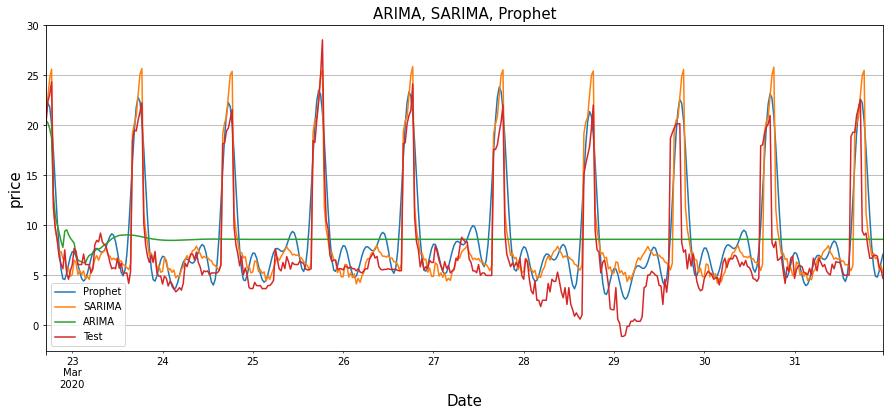

In [220]:
ax=forecast.plot(x='ds',y='yhat', figsize=(15,6))
sarimapred.plot()
arimapred.plot()
test['price'].plot(legend = True)
plt.ylabel('price', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.title('ARIMA, SARIMA, Prophet', fontsize=15)
plt.legend(['Prophet','SARIMA','ARIMA','Test'])
plt.grid()